In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CSCI 436 BIOGAS PROJECT
!ls

/content/drive/MyDrive/CSCI 436 BIOGAS PROJECT
caiso_2021-22.csv		  CaliTempV1.ipynb	    CSCI_436_PROJECT_REPORT.gdoc
CaliData_LinearRegression.ipynb   CaliTempV2.ipynb	    DecisionTreeRegression.ipynb
Cali-GAS-MVF-10-Year-Report.xlsx  Clustering.ipynb	    LinearRegression.ipynb
CaliRenewProd2010-18.csv	  CSCI_436_PROJECT.gslides


In [ ]:
#row test display
file_path = r'/content/drive/My Drive/CSCI 436 BIOGAS PROJECT/CaliRenewProd2010-18.csv'
df = pd.read_csv(file_path)
print(df.head())

             TIMESTAMP  BIOGAS  BIOMASS  GEOTHERMAL  Hour  SMALL HYDRO  SOLAR  \
0  2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0    0.0   
1  2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0    0.0   
2  2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0    0.0   
3  2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0    0.0   
4  2011-07-21 04:00:00   177.0    377.0       984.0   5.0        508.0    0.0   

   SOLAR PV  SOLAR THERMAL  WIND TOTAL  
0       NaN            NaN      1607.0  
1       NaN            NaN      1619.0  
2       NaN            NaN      1660.0  
3       NaN            NaN      1633.0  
4       NaN            NaN      1520.0  


# START Spark CLustering Model

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=27b397ee239ac3c416be6404c5d4a40126cb2313d8a4dea9fdc3dfd3ae732dcb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


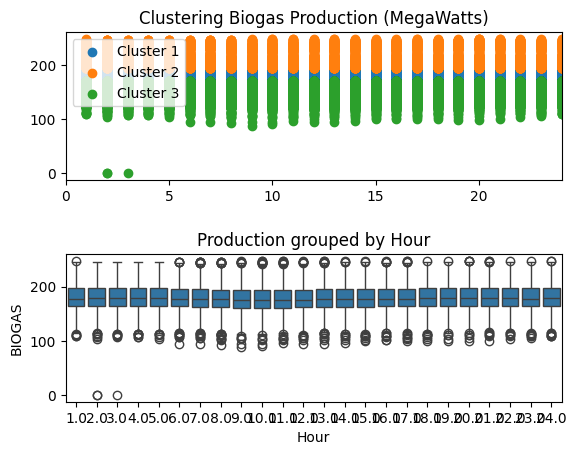

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Create a Spark session
spark = SparkSession.builder \
    .appName("BiogasClustering") \
    .getOrCreate()

df_spark = spark.createDataFrame(df)

vecAssembler = VectorAssembler(inputCols=['BIOGAS', 'Hour'], outputCol='features')
data = vecAssembler.transform(df_spark)

# Clustering with K-means using Spark MLlib
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(data)
clustered_data = model.transform(data)

# Convert back to Pandas DataFrame for plotting
clustered_df = clustered_data.toPandas()

plt.subplot(2, 1, 1)
for cluster_id in range(3): #3 assumed clusters
    mask = (clustered_df['prediction'] == cluster_id)
    plt.scatter(clustered_df.loc[mask, 'Hour'], clustered_df.loc[mask, 'BIOGAS'], label=f'Cluster {cluster_id + 1}')

plt.legend(loc='upper left')
plt.xlim([0, 24])  # Assuming Hour ranges from 0 to 24
plt.title('Clustering Biogas Production (MegaWatts)')

plt.subplot(2, 1, 2)
sns.boxplot(x='Hour', y='BIOGAS', data=df)  # Specify x and y variables from original Pandas DataFrame
plt.title('Production grouped by Hour')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

# Stop the Spark session
spark.stop()

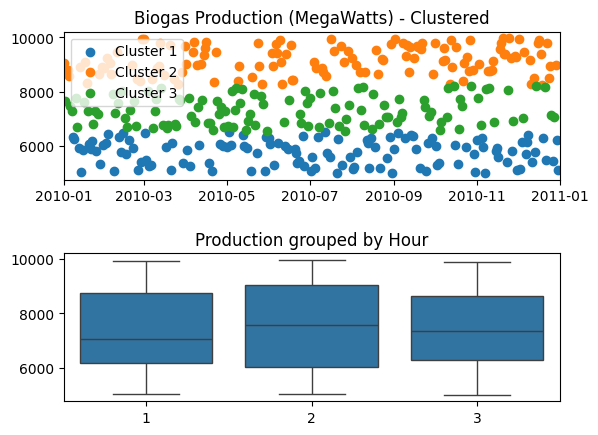

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

spark = SparkSession.builder \
    .appName("BiogasClustering") \
    .getOrCreate()

x = pd.date_range(start='2010-01-01', end='2010-12-31', freq='D')
y = np.random.randint(5000, 10000, len(x))
hour = np.random.randint(1, 4, len(x))

# Convert NumPy arrays to Spark DataFrames
data = spark.createDataFrame(pd.DataFrame({'x': x, 'y': y, 'hour': hour}))

# Vectorize
vecAssembler = VectorAssembler(inputCols=['y', 'hour'], outputCol='features')
data = vecAssembler.transform(data)

# Clustering with K-means using Spark MLlib
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(data)
clustered_data = model.transform(data)

clustered_df = clustered_data.toPandas()

plt.subplot(2, 1, 1)
for cluster_id in range(3):
    mask = (clustered_df['prediction'] == cluster_id)
    plt.scatter(clustered_df.loc[mask, 'x'], clustered_df.loc[mask, 'y'], label=f'Cluster {cluster_id + 1}')

plt.legend(loc='upper left')
plt.xlim([pd.to_datetime('01/01/2010'), pd.to_datetime('01/01/2011')])
plt.title('Biogas Production (MegaWatts) - Clustered')

plt.subplot(2, 1, 2)
sns.boxplot(x=hour, y=y)  # Specify x and y variables
plt.title('Production grouped by Hour')

plt.subplots_adjust(hspace=0.5) #soace adjust

plt.show()

spark.stop()

# Non Spark Model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


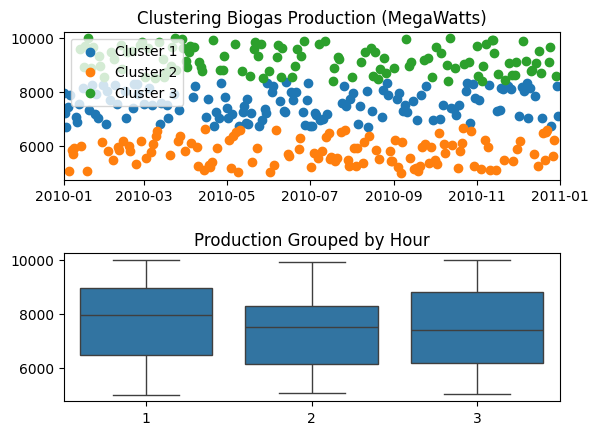

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# from sklearn.cluster import KMeans

# x = pd.date_range(start='2010-01-01', end='2010-12-31', freq='D')
# y = np.random.randint(5000, 10000, len(x))
# hour = np.random.randint(1, 4, len(x))

# # Clustering with K-means
# kmeans = KMeans(n_clusters=3)
# data_for_clustering = np.column_stack((y, hour))
# cluster_labels = kmeans.fit_predict(data_for_clustering)

# plt.subplot(2, 1, 1)

# for cluster_id in range(3):  # 3 clusters
#     mask = (cluster_labels == cluster_id)
#     plt.scatter(x[mask], y[mask], label=f'Cluster {cluster_id + 1}')

# plt.legend(loc='upper left')
# plt.xlim([pd.to_datetime('01/01/2010'), pd.to_datetime('01/01/2011')])
# plt.title('Clustering Biogas Production (MegaWatts)')

# plt.subplot(2, 1, 2)
# sns.boxplot(x=hour, y=y)
# plt.title('Production Grouped by Hour')

# plt.subplots_adjust(hspace=0.5)

# plt.show()

# data points within the same color layer have similar biogas production levels and hour values

In [ ]:
x = df.index
y =  df['Biogas'.upper()]
hour = df['Hour'].astype(int)
quart_day = hour // 4

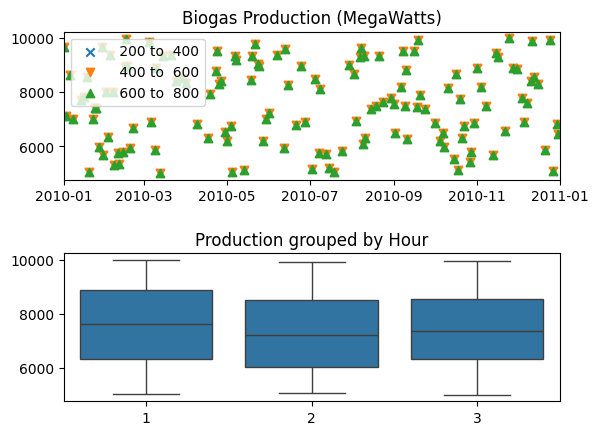

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

x = pd.date_range(start='2010-01-01', end='2010-12-31', freq='D')
y = np.random.randint(5000, 10000, len(x))
hour = np.random.randint(1, 4, len(x))

mask = (hour == 1)

plt.subplot(2, 1, 1)

for h, marker in [(1, 'x'), (2, 'v'), (3, '^')]:
    plt.scatter(x[mask], y[mask], marker=marker, label='{:2}00 to {:2}00'.format(h*2, (h+1)*2))
plt.legend(loc='upper left')
plt.xlim([pd.to_datetime('01/01/2010'), pd.to_datetime('01/01/2011')])
plt.title('Biogas Production (MegaWatts)')

plt.subplot(2, 1, 2)
sns.boxplot(x=hour, y=y)
plt.title('Production grouped by Hour')

plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
x1 = df.index
y2 =  df['Biomass'.upper()]
hour = df['Hour'].astype(int)
quart_day = hour // 4

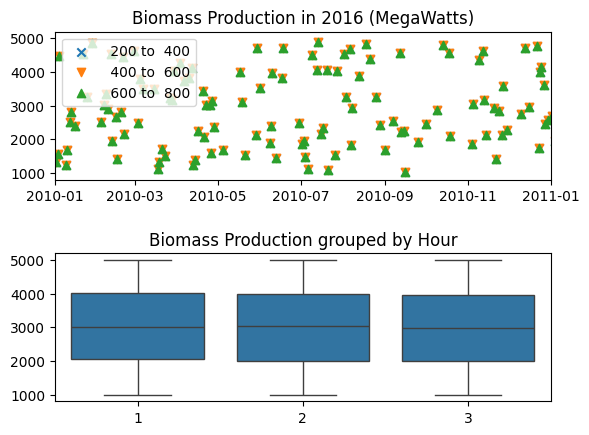

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Generate example data for biogas production
x1 = pd.date_range(start='2010-01-01', end='2018-12-31', freq='D')
y2 = np.random.randint(1000, 5000, len(x1))
hour = np.random.randint(1, 4, len(x1))

mask = (hour == 1)

plt.subplot(2, 1, 1)

for h, marker in [(1, 'x'), (2, 'v'), (3, '^')]:
    plt.scatter(x1[mask], y2[mask], marker=marker, label='{:2}00 to {:2}00'.format(h*2, (h+1)*2))
plt.legend(loc='upper left')
plt.xlim([pd.to_datetime('01/01/2010'), pd.to_datetime('01/01/2011')])
plt.title('Biomass Production in 2016 (MegaWatts)')

plt.subplot(2, 1, 2)
sns.boxplot(x=hour, y=y2)  # Corrected y variable to y2
plt.title('Biomass Production grouped by Hour')

plt.subplots_adjust(hspace=0.5)

plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67584 entries, 0 to 67583
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TIMESTAMP      67584 non-null  object 
 1   BIOGAS         67584 non-null  float64
 2   BIOMASS        67584 non-null  float64
 3   GEOTHERMAL     67584 non-null  float64
 4   Hour           67584 non-null  float64
 5   SMALL HYDRO    67584 non-null  float64
 6   SOLAR          22680 non-null  float64
 7   SOLAR PV       44904 non-null  float64
 8   SOLAR THERMAL  44904 non-null  float64
 9   WIND TOTAL     67584 non-null  float64
dtypes: float64(9), object(1)
memory usage: 5.2+ MB
None
                 BIOGAS   BIOMASS  GEOTHERMAL      Hour  SMALL HYDRO  \
BIOGAS         1.000000  0.018301   -0.380714  0.009720    -0.197017   
BIOMASS        0.018301  1.000000   -0.120966  0.042913    -0.024100   
GEOTHERMAL    -0.380714 -0.120966    1.000000 -0.019260     0.050206   
Hour           0.0

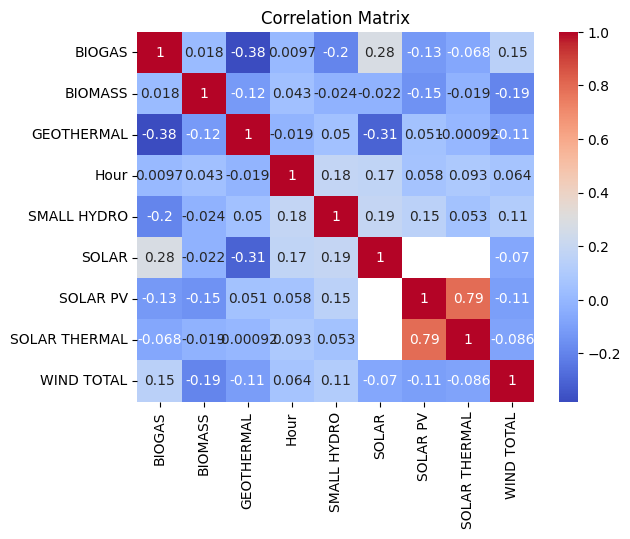

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('CaliRenewProd2010-18.csv')

# Inspect the data to understand the columns and their types
print(data.info())

# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=['number'])

# Correlation matrix
correlation_matrix = numeric_data.corr()
print(correlation_matrix)

# Visualizing the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Load your data
data = pd.read_csv('CaliRenewProd2010-18.csv')

# Inspect the DataFrame to understand its structure and column names
print(data.columns)

# Convert the 'TIMESTAMP' column to datetime and then to a numeric format
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data['TIMESTAMP_NUM'] = data['TIMESTAMP'].astype(int) // 10**9  # Convert to Unix timestamp

# Define dependent and independent variables
X = data[['TIMESTAMP_NUM',]]  # Ensure these columns are numeric
y = data['BIOMASS']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


Index(['TIMESTAMP', 'BIOGAS', 'BIOMASS', 'GEOTHERMAL', 'Hour', 'SMALL HYDRO',
       'SOLAR', 'SOLAR PV', 'SOLAR THERMAL', 'WIND TOTAL'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                 3.366e+04
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        05:16:49   Log-Likelihood:            -3.6280e+05
No. Observations:               67584   AIC:                         7.256e+05
Df Residuals:                   67582   BIC:                         7.256e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t    

In [ ]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Load your data
data = pd.read_csv('CaliRenewProd2010-18.csv')

# Inspect the DataFrame to understand its structure and column names
print(data.columns)

# Convert the 'TIMESTAMP' column to datetime and then to a numeric format
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data['TIMESTAMP_NUM'] = data['TIMESTAMP'].astype(int) // 10**9  # Convert to Unix timestamp

# Define dependent and independent variables
X = data[['TIMESTAMP_NUM',]]  # Ensure these columns are numeric
y = data['BIOGAS']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

Index(['TIMESTAMP', 'BIOGAS', 'BIOMASS', 'GEOTHERMAL', 'Hour', 'SMALL HYDRO',
       'SOLAR', 'SOLAR PV', 'SOLAR THERMAL', 'WIND TOTAL'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                 BIOGAS   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        05:16:49   Log-Likelihood:            -3.0005e+05
No. Observations:               67584   AIC:                         6.001e+05
Df Residuals:                   67582   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t    